In [3]:
# This is an example snippet!
# To create your own, add a new snippet block to the
# snippets.json file in your jupyter nbextensions directory:
# /nbextensions/snippets/snippets.json
import json
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from collections import defaultdict
from matplotlib.animation import FuncAnimation

%matplotlib notebook
# from warnings import filterwarnings
# filterwarnings('ignore')

## Compare openpose and detectron predictions

In [ ]:
!mv data_2d_custom_videos.npy data_2d_custom_videos.npz

In [38]:
frames = []

for path in sorted(Path('data/jsons').glob('Untitled_00000000*')):
    with open(path) as file:
        try:
            keypoints = json.load(file)['people'][0]['pose_keypoints_2d']
        except IndexError:
            keypoints = [0] * 54
    frames.append([keypoints[::3], keypoints[1::3]])

frames = np.array(frames).transpose(0, 2, 1)
frames = np.delete(frames, (1,), axis=1)

In [40]:
detectron = np.load('data/data_2d_custom_videos.npz', allow_pickle=True)['positions_2d'].item()['Untitled.mov']['custom'][0]

<IPython.core.display.Javascript object>


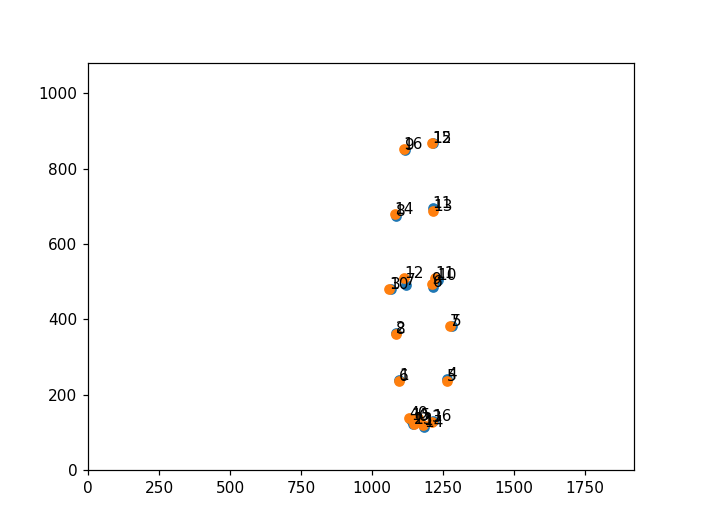

In [95]:
fig, ax = plt.subplots()

def update(frame_id):
    ax.clear()
    
    for arr in (frames, detectron):
        x, y = zip(*arr[frame_id])
        ax.scatter(x, y)
        for i in range(len(x)):
            ax.annotate(i, (x[i], y[i]))
    
    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 1080)
    

fps = 29.7
ani = FuncAnimation(fig, update, len(openpose), interval=1000 / fps)
ani.save('/Users/starlight/Desktop/top_view.mp4', writer='ffmpeg')
plt.show()

In [111]:
diffs = np.stack([
    np.subtract.outer(frames[400], detectron[400])[:, 0, :, 0],
    np.subtract.outer(frames[400], detectron[400])[:, 1, :, 1]], -1)

distances = np.sum(diffs ** 2, -1)

In [119]:
# Frames in detectron
distances.argmin(0)

array([ 0, 14, 13, 16, 15,  4,  1,  5,  2,  6,  3, 10,  7, 11,  8, 12,  9])

<IPython.core.display.Javascript object>


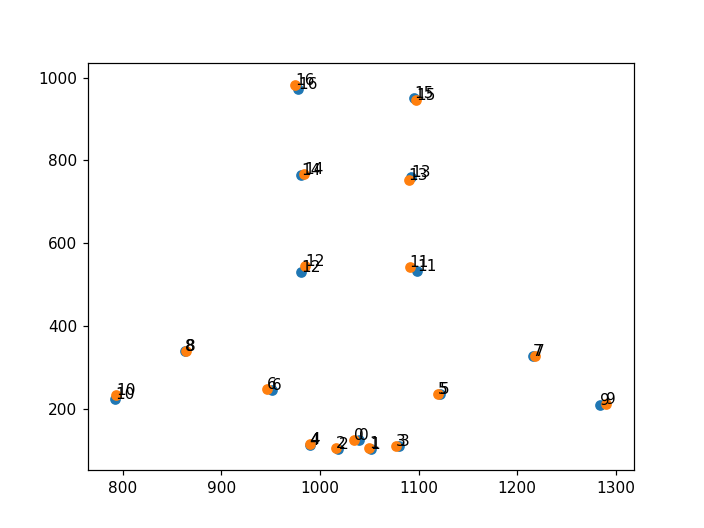

In [120]:
fig, ax = plt.subplots()

for arr in (frames[:, distances.argmin(0)], detectron):
    x, y = zip(*arr[400])
    ax.scatter(x, y)
    for i in range(len(x)):
        ax.annotate(i, (x[i], y[i]))

## Injest openpose predictions to VideoPose3D dataset

In [121]:
dataset = dict(np.load('data/data_2d_custom_videos.npz', allow_pickle=True))

In [122]:
item = dataset['positions_2d'].item()

In [123]:
item['Untitled.mov']['custom'][0] = \
    np.concatenate([frames[:, distances.argmin(0)], np.zeros_like(detectron)[:detectron.shape[0] - frames.shape[0]]])

In [124]:
dataset['positions_2d'] = np.array(item)

In [125]:
with open('data_2d_custom_videos.npz', 'wb') as file:
    pickle.dump(dataset, file)

In [71]:
loaded = np.load('data_2d_custom_videos.npz', allow_pickle=True)